In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# import config as cfg
from torch.utils.data import DataLoader
from models.configurable_cnn import ConfigurableCNN
from training.trainer import train_model
from training.utils import set_seed, save_config_to_json

from config import Config

def load_cached_dataset(location, cfg, path_format="cached_datasets/datasets_{location}_256.pkl"):
    """
    Load a cached dataset for a specific location.

    Args:
    - location (str): The location whose dataset should be loaded.

    Returns:
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - label_mapping: Dictionary mapping labels to indices.
    """
    dataset_path = cfg.DATA_PATH / path_format.format(location=location)
    print(f"Loading cached dataset from: {dataset_path}")

    with open(dataset_path, "rb") as f:
        train_dataset, val_dataset = pickle.load(f)

    train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)
    return train_loader

In [23]:
cfg = Config()
train_loader = load_cached_dataset("ls data/ben_bucket/cached_datasets/", cfg)

def train_single_class_generator(train_loader, class_idx=0):
    for flowpics, labels in train_loader:
        for flowpic, label in zip(flowpics, labels):
            if label == class_idx:
                yield flowpic, label

Loading cached dataset from: data/ben_bucket/cached_datasets/datasets_ls data/ben_bucket/cached_datasets/_256.pkl


FileNotFoundError: [Errno 2] No such file or directory: 'data/ben_bucket/cached_datasets/datasets_ls data/ben_bucket/cached_datasets/_256.pkl'

In [3]:
path = Path('/home/anatbr/dataset/Allot/ver02 - Location 01 - 2024.09.06-09.csv G Z')

In [11]:
# Exploratory Data Analysis Notebook

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv(path, nrows=1000000)


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2024-09-05 10:49:11 to 2024-09-05 16:00:22
Data columns (total 15 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   timeSec1970   1000000 non-null  int64 
 1   timeMs        1000000 non-null  int64 
 2   appId         1000000 non-null  int64 
 3   ipAddrClient  1000000 non-null  object
 4   ipAddrServer  1000000 non-null  object
 5   portClient    1000000 non-null  int64 
 6   portServer    1000000 non-null  int64 
 7   protocol      1000000 non-null  int64 
 8   ppiLen        1000000 non-null  int64 
 9   ppi-pdt       1000000 non-null  object
 10  ppi-pd        1000000 non-null  object
 11  ppi-ps        1000000 non-null  object
 12  ppi-paux      1000000 non-null  object
 13  packet_sizes  1000000 non-null  object
 14  num_packets   1000000 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 122.1+ MB

--- First few rows ---
         

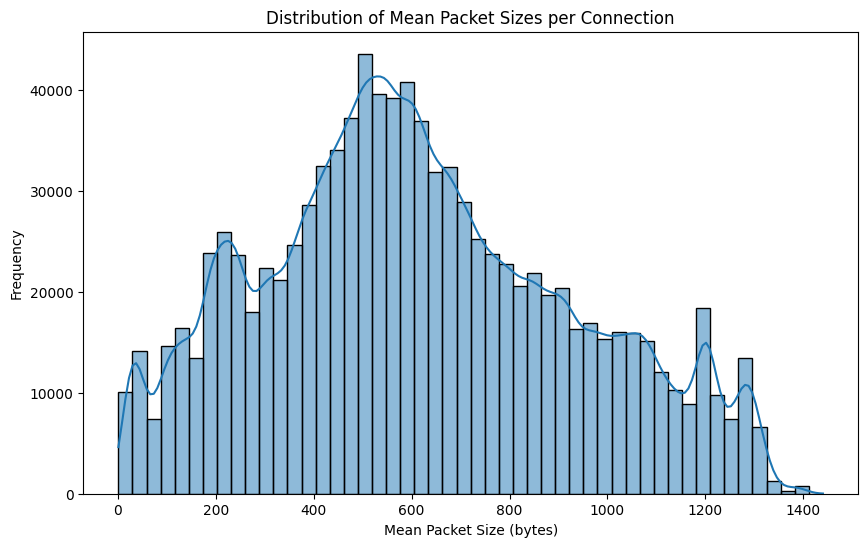

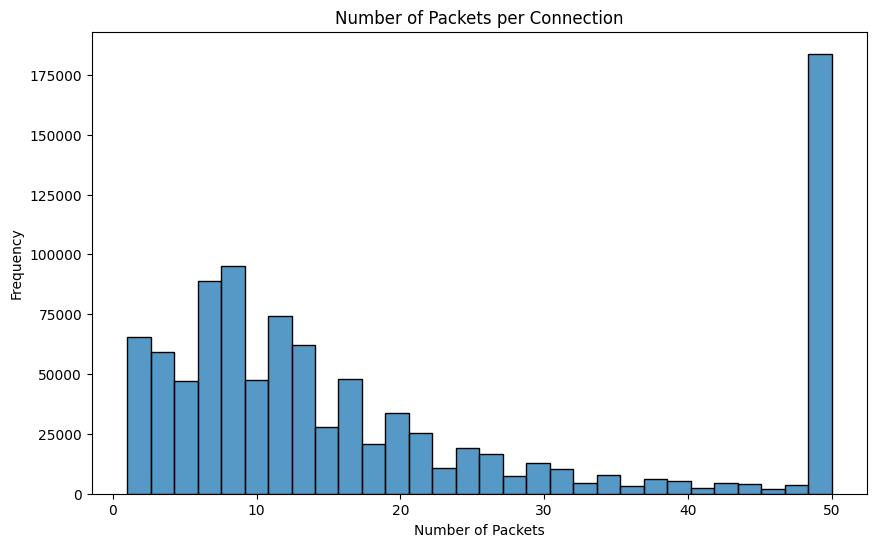

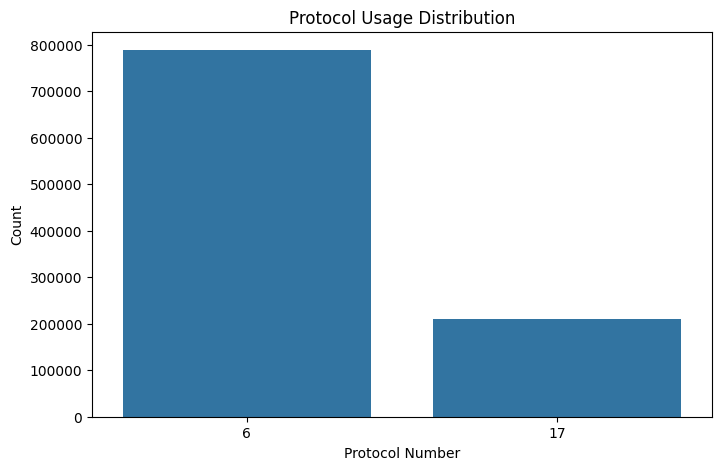

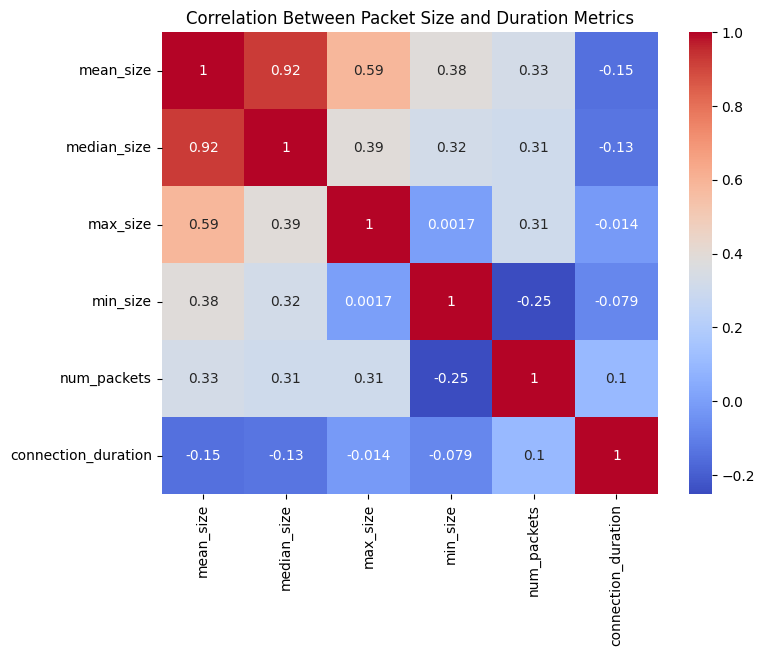

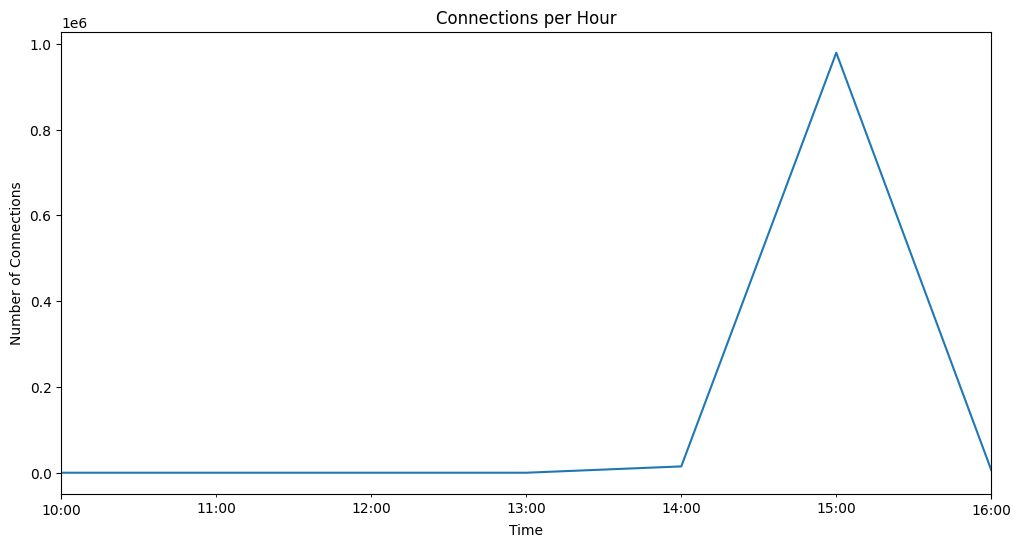

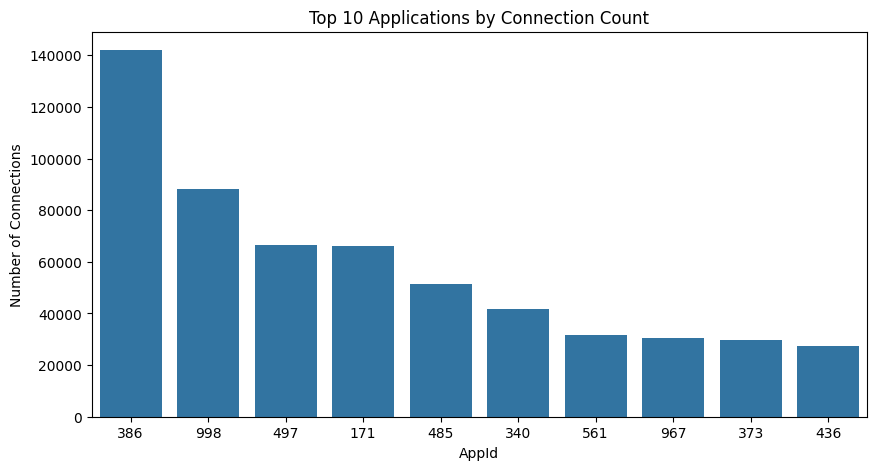

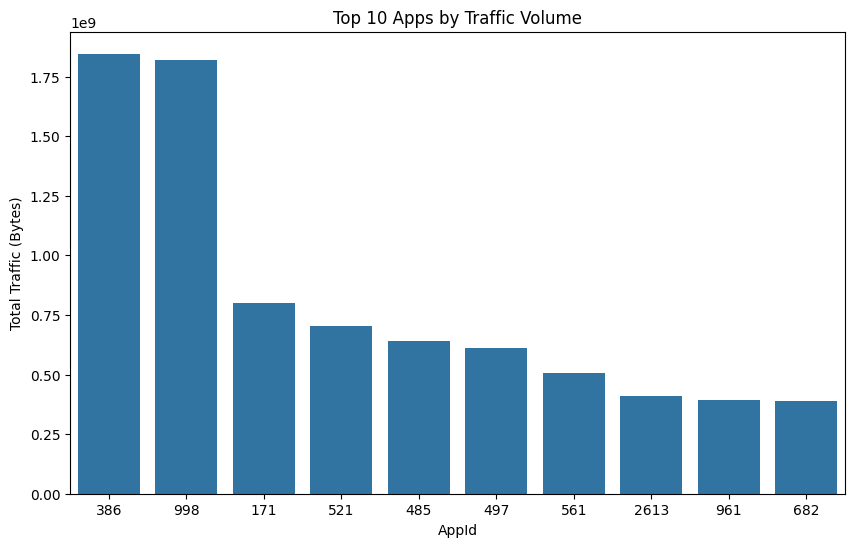

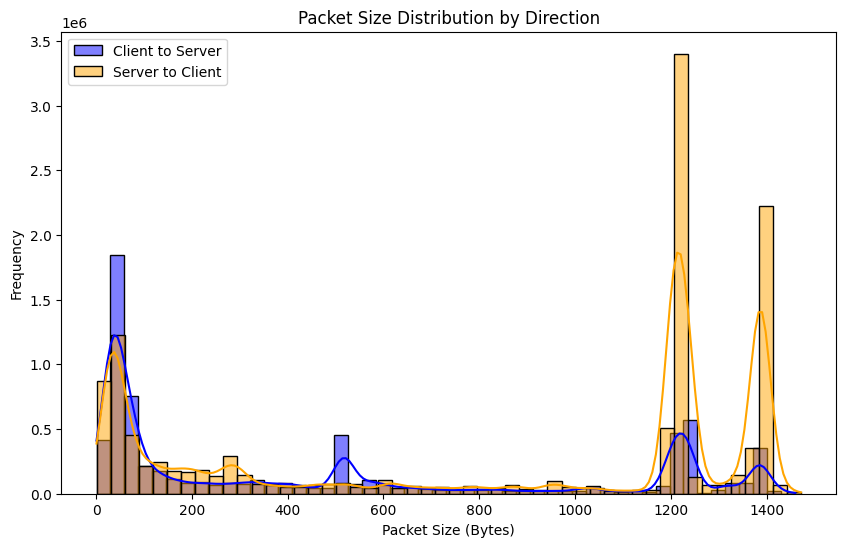

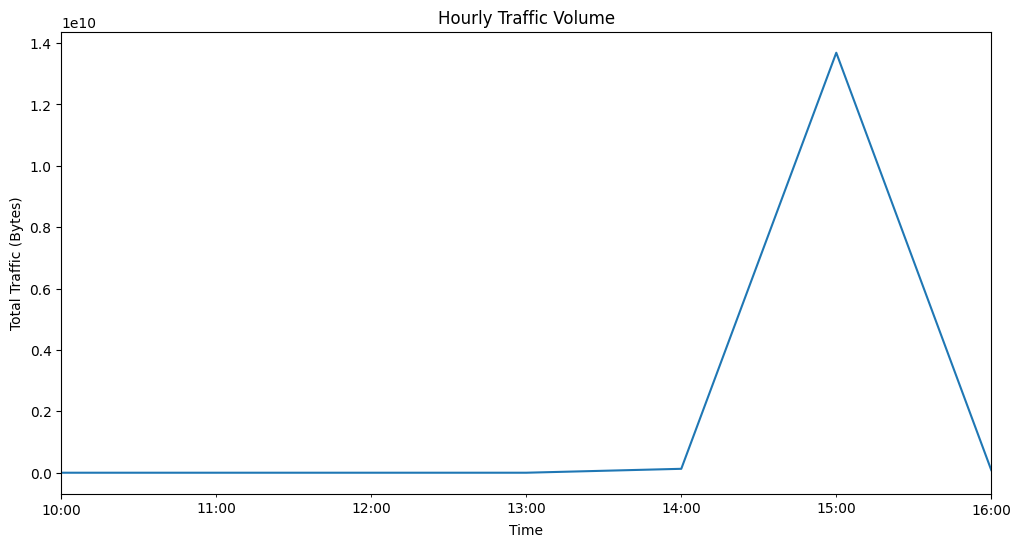

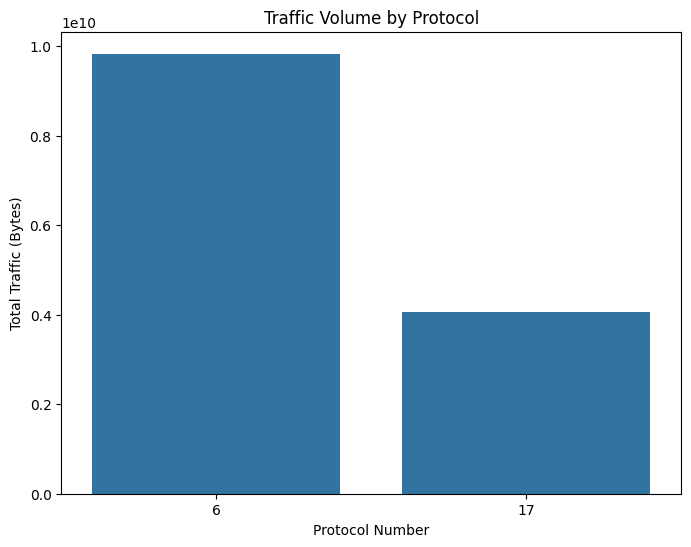

In [ ]:

# Overview of dataset
print("--- Dataset Info ---")
data.info()
print("\n--- First few rows ---")
print(data.head())

# Parsing packet sizes and times
data['packet_sizes'] = data['ppi-ps'].apply(lambda x: [int(num) for num in x.strip('[]').split()])
data['num_packets'] = data['packet_sizes'].apply(len)
data['packet_times'] = data['ppi-pdt'].apply(lambda x: [int(num) for num in x.strip('[]').split()])
data['directions'] = data['ppi-pd'].apply(lambda x: [int(num) for num in x.strip('[]').split()])

# Connection duration calculation
data['connection_duration_ms'] = data['packet_times'].apply(lambda x: max(x) - min(x))

# Statistical summary
packet_size_stats = pd.DataFrame({
    'mean_size': data['packet_sizes'].apply(np.mean),
    'median_size': data['packet_sizes'].apply(np.median),
    'max_size': data['packet_sizes'].apply(np.max),
    'min_size': data['packet_sizes'].apply(np.min),
    'num_packets': data['num_packets'],
    'connection_duration': data['connection_duration_ms']
})

print("\n--- Statistical Summary of Packet Sizes and Connection Duration ---")
print(packet_size_stats.describe())

# Traffic volume calculation
data['total_bytes'] = data['packet_sizes'].apply(sum)

# Distribution of Mean Packet Sizes
plt.figure(figsize=(10, 6))
sns.histplot(packet_size_stats['mean_size'], bins=50, kde=True)
plt.title('Distribution of Mean Packet Sizes per Connection')
plt.xlabel('Mean Packet Size (bytes)')
plt.ylabel('Frequency')
plt.show()

# Number of Packets per Connection
plt.figure(figsize=(10, 6))
sns.histplot(packet_size_stats['num_packets'], bins=30, kde=False)
plt.title('Number of Packets per Connection')
plt.xlabel('Number of Packets')
plt.ylabel('Frequency')
plt.show()

# Protocol Usage Distribution
protocol_counts = data['protocol'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=protocol_counts.index, y=protocol_counts.values)
plt.title('Protocol Usage Distribution')
plt.xlabel('Protocol Number')
plt.ylabel('Count')
plt.show()

# Correlation Analysis
plt.figure(figsize=(8, 6))
sns.heatmap(packet_size_stats.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Packet Size and Duration Metrics')
plt.show()

# Connections per Hour
data['timestamp'] = pd.to_datetime(data['timeSec1970'], unit='s')
data.set_index('timestamp', inplace=True)
data.resample('H').size().plot(figsize=(12, 6))
plt.title('Connections per Hour')
plt.xlabel('Time')
plt.ylabel('Number of Connections')
plt.show()

# Top 10 Applications by Connection Count
app_counts = data['appId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=app_counts.index.astype(str), y=app_counts.values)
plt.title('Top 10 Applications by Connection Count')
plt.xlabel('AppId')
plt.ylabel('Number of Connections')
plt.show()

# Traffic Volume per Application
top_apps_volume = data.groupby('appId')['total_bytes'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_apps_volume.index.astype(str), y=top_apps_volume.values)
plt.title('Top 10 Apps by Traffic Volume')
plt.xlabel('AppId')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

# Packet Size Distribution by Direction
client_to_server_sizes = [size for sizes, dirs in zip(data['packet_sizes'], data['directions']) for size, d in zip(sizes, dirs) if d == 0]
server_to_client_sizes = [size for sizes, dirs in zip(data['packet_sizes'], data['directions']) for size, d in zip(sizes, dirs) if d == 1]

plt.figure(figsize=(10,6))
sns.histplot(client_to_server_sizes, bins=50, kde=True, color='blue', label='Client to Server')
sns.histplot(server_to_client_sizes, bins=50, kde=True, color='orange', label='Server to Client')
plt.title('Packet Size Distribution by Direction')
plt.xlabel('Packet Size (Bytes)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Hourly Traffic Volume
hourly_traffic = data['total_bytes'].resample('H').sum()
plt.figure(figsize=(12,6))
hourly_traffic.plot()
plt.title('Hourly Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

# Protocol-wise Traffic Volume
protocol_traffic = data.groupby('protocol')['total_bytes'].sum()
plt.figure(figsize=(8,6))
sns.barplot(x=protocol_traffic.index.astype(str), y=protocol_traffic.values)
plt.title('Traffic Volume by Protocol')
plt.xlabel('Protocol Number')
plt.ylabel('Total Traffic (Bytes)')
plt.show()
